## 环境配置

### Conda + Python  
https://docs.conda.io/en/latest/

### Pycharm/Vscode + Jupyter  
https://www.jetbrains.com/pycharm/download/?section=windows  
https://code.visualstudio.com/  
IDE内可以直接下载Jupyter

### Github  
https://gitforwindows.org/  
注册Github账号  
下载gitforwindows  
本地设置账密  
连接线上代码库  
不上传数据文件  

## 探索性数据分析 EDA  
快速了解数据  
得到更加干净有效的数据 便于后续的特征工程  
以application为例，bureau需要自己完成

### 数据读取  
将csv文件读取到内存中  
依赖pandas   
生成一个带有各列解释的数据表

In [202]:
import numpy as np 
import pandas as pd 
import warnings 
# import polars

warnings.filterwarnings("ignore")

train_url = '../data/application_train.csv'
test_url = '../data/application_test.csv'
des_url = '../data/HomeCredit_columns_description.csv'

## 读取数据
app_train = pd.read_csv(train_url, encoding = "", sep = ',')
app_test = pd.read_csv(test_url, encoding = "")
des = pd.read_csv(des_url, usecols = ['Row', 'Table', 'Description'])
print('shape of application train = ', app_train.shape)
print('shape of application test = ', app_test.shape)

shape of application train =  (307511, 122)
shape of application test =  (48744, 121)


In [203]:
app_train = pd.read_csv(train_url, encoding = "", sep = ',')
app_test = pd.read_csv(test_url, encoding = "")
des = pd.read_csv(des_url, usecols = ['Row', 'Table', 'Description'])
print('shape of application train = ', app_train.shape)
print('shape of application test = ', app_test.shape)

shape of application train =  (307511, 122)
shape of application test =  (48744, 121)


In [204]:
## 分离训练集中的预测目标
y = app_train[['SK_ID_CURR', 'TARGET']]
app_train = app_train.drop(labels = 'TARGET', axis = 1)

In [205]:
## 生成特征解释表
feature_des = pd.DataFrame(app_train.columns, columns = ['Row'])
feature_des = pd.merge(feature_des, des, on = 'Row', how = 'left')
feature_des = feature_des[feature_des['Table'] == 'application_{train|test}.csv'].reset_index(drop = True)
feature_des

,Row,Table,Description
0,SK_ID_CURR,application_{train|test}.csv,ID of loan in our sample
1,NAME_CONTRACT_TYPE,application_{train|test}.csv,Identification if loan is cash or revolving
2,CODE_GENDER,application_{train|test}.csv,Gender of the client
3,FLAG_OWN_CAR,application_{train|test}.csv,Flag if the client owns a car
4,FLAG_OWN_REALTY,application_{train|test}.csv,Flag if client owns a house or flat
...,...,...,...
116,AMT_REQ_CREDIT_BUREAU_DAY,application_{train|test}.csv,Number of enquiries to Credit Bureau about the...
117,AMT_REQ_CREDIT_BUREAU_WEEK,application_{train|test}.csv,Number of enquiries to Credit Bureau about the...
118,AMT_REQ_CREDIT_BUREAU_MON,application_{train|test}.csv,Number of enquiries to Credit Bureau about the...
119,AMT_REQ_CREDIT_BUREAU_QRT,application_{train|test}.csv,Number of enquiries to Credit Bureau about the...


### 数据清洗  
重复值/缺失值/异常值处理  
依赖pandas, numpy  
各列数据类型以及训练/测试集数据缺失率  
考虑剔除训练集和测试集缺失率差异过大的列  
结合数据类型，考虑填充缺失值  
缺失率高的列需要单独分析

In [206]:
## 重复值删除
print('application train id duplicates = ', app_train.SK_ID_CURR.duplicated().sum())
print('application test id duplicates = ', app_test.SK_ID_CURR.duplicated().sum())

application train id duplicates =  0
application test id duplicates =  0


In [207]:
## 数据类型 & 缺失率
feature_des['Dtype'] = list(app_train.dtypes)
feature_des['Missing_train'] = list(app_train.isna().sum() / len(app_train))
feature_des['Missing_test'] = list(app_test.isna().sum() / len(app_test))
feature_des

,Row,Table,Description,Dtype,Missing_train,Missing_test
0,SK_ID_CURR,application_{train|test}.csv,ID of loan in our sample,int64,0.000000,0.000000
1,NAME_CONTRACT_TYPE,application_{train|test}.csv,Identification if loan is cash or revolving,object,0.000000,0.000000
2,CODE_GENDER,application_{train|test}.csv,Gender of the client,object,0.000000,0.000000
3,FLAG_OWN_CAR,application_{train|test}.csv,Flag if the client owns a car,object,0.000000,0.000000
4,FLAG_OWN_REALTY,application_{train|test}.csv,Flag if client owns a house or flat,object,0.000000,0.000000
...,...,...,...,...,...,...
116,AMT_REQ_CREDIT_BUREAU_DAY,application_{train|test}.csv,Number of enquiries to Credit Bureau about the...,float64,0.135016,0.124097
117,AMT_REQ_CREDIT_BUREAU_WEEK,application_{train|test}.csv,Number of enquiries to Credit Bureau about the...,float64,0.135016,0.124097
118,AMT_REQ_CREDIT_BUREAU_MON,application_{train|test}.csv,Number of enquiries to Credit Bureau about the...,float64,0.135016,0.124097
119,AMT_REQ_CREDIT_BUREAU_QRT,application_{train|test}.csv,Number of enquiries to Credit Bureau about the...,float64,0.135016,0.124097


In [208]:
## 剔除训练/测试集缺失率差异过大的列
drop_cols = {}
feature_des['Missing_diff'] = np.abs(feature_des.Missing_train - feature_des.Missing_test)
feature_des.sort_values(by = 'Missing_diff')
drop_cols['EXT_SOURCE_1'] = 'missing rate gap'
drop_cols

{'EXT_SOURCE_1': 'missing rate gap'}

In [209]:
## 数值类型填充缺失值，字符串类型暂不填充
def missing_padding(train, test, feature, padding_type, custom_value = -999):
    padding_value = np.nan
    if padding_type == 'mean':
        padding_value = train[feature].mean()
    elif padding_type == 'median':
        padding_value = train[feature].median()
    elif padding_type == 'custom':
        padding_value = custom_value
    train[feature] = train[feature].fillna(padding_value)
    test[feature] = test[feature].fillna(padding_value)

for index, row in feature_des.iterrows():
    if row.Dtype in ('int64', 'float64'):
        missing_padding(app_train, app_test, row.Row, 'mean')
    else:
        pass

### 数据分布

训练测试集的平均值、分位数、方差以及枚举值个数  
依赖pandas, numpy  

In [210]:
## nfeatures: 数值特征
## cfeatures: 枚举特征
nfeatures = list(feature_des[(feature_des.Dtype == 'int64') | (feature_des.Dtype == 'float64')].Row)
cfeatures = list(feature_des[feature_des.Dtype == 'object'].Row)
print('数值特征:', nfeatures)
print('类别特征:', cfeatures)

## 简便方式
print('训练集-数值特征')
display(app_train[nfeatures].describe())
print('训练集-类别特征')
display(app_train[cfeatures].describe())

print('测试集-数值特征')
display(app_train[nfeatures].describe())
print('测试集-类别特征')
display(app_train[cfeatures].describe())

数值特征: ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BU

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.454517,3.692794e+05,0.013831,4363.988632,141275.766519,3522.886321,...,0.089798,0.024387,0.022518,0.018299,0.077983,0.103009,0.190366,0.851923,0.738507,1.738528
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,278202.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.899974
75%,367142.500000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267395,0.265474,3.000000
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


训练集-类别特征


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


测试集-数值特征


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.454517,3.692794e+05,0.013831,4363.988632,141275.766519,3522.886321,...,0.089798,0.024387,0.022518,0.018299,0.077983,0.103009,0.190366,0.851923,0.738507,1.738528
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,278202.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.899974
75%,367142.500000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267395,0.265474,3.000000
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


测试集-类别特征


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


#### 数值类型特征的均值/分位数/方差  

In [211]:
## 数值类型特征取平均、中位数、标准差
## 将结果转置
train_mean = app_train[nfeatures].agg(['mean', 'median', 'std']).transpose().reset_index()
train_mean.rename({'index': 'Row', 'mean': 'train_mean', 'median': 'train_median', 'std': 'train_std'}, axis = 1, inplace = True)
## 拼接原表
feature_des = feature_des.merge(train_mean, on = 'Row', how = 'left')

## 对测试集做同样操作
test_mean = app_test[nfeatures].agg(['mean', 'median']).transpose().reset_index()
test_mean.rename({'index': 'Row', 'mean': 'test_mean', 'median': 'test_median', 'std': 'test_std'}, axis = 1, inplace = True)
feature_des = feature_des.merge(test_mean, on = 'Row', how = 'left')

## 对比训练测试集的变化率
feature_des['mean_change_rate'] = np.abs(feature_des['test_mean'] - feature_des['train_mean']) / feature_des['train_mean']
feature_des['median_change_rate'] = np.abs(feature_des['test_mean'] - feature_des['train_mean']) / feature_des['train_mean']

## 提取变化率较大的特征
change_feature_list = list(feature_des[(feature_des.mean_change_rate > 0.5) & (feature_des.median_change_rate > 0.5)].Row)
for change_feature in change_feature_list:
    drop_cols[change_feature] = 'distribution gap'
print('分布变化较大的数值类型特征:', change_feature_list)

26                     FLAG_EMAIL
95                FLAG_DOCUMENT_2
100               FLAG_DOCUMENT_7
103              FLAG_DOCUMENT_10
104              FLAG_DOCUMENT_11
105              FLAG_DOCUMENT_12
106              FLAG_DOCUMENT_13
107              FLAG_DOCUMENT_14
108              FLAG_DOCUMENT_15
109              FLAG_DOCUMENT_16
110              FLAG_DOCUMENT_17
111              FLAG_DOCUMENT_18
112              FLAG_DOCUMENT_19
113              FLAG_DOCUMENT_20
114              FLAG_DOCUMENT_21
115    AMT_REQ_CREDIT_BUREAU_HOUR
116     AMT_REQ_CREDIT_BUREAU_DAY
117    AMT_REQ_CREDIT_BUREAU_WEEK
118     AMT_REQ_CREDIT_BUREAU_MON
119     AMT_REQ_CREDIT_BUREAU_QRT
Name: Row, dtype: object

#### 字符串类型特征的枚举值

In [212]:
## 枚举类型取枚举值个数
train_nunique = app_train[cfeatures].nunique().transpose().reset_index()
train_nunique.rename({'index': 'Row', 0: 'train_nunique'}, axis = 1, inplace = True)
## 拼接原表
feature_des = feature_des.merge(train_nunique, on = 'Row', how = 'left')

## 对测试集做同样操作
test_nunique = app_test[cfeatures].nunique().transpose().reset_index()
test_nunique.rename({'index': 'Row', 0: 'test_nunique'}, axis = 1, inplace = True)
feature_des = feature_des.merge(test_nunique, on = 'Row', how = 'left')

## 对比训练测试集的枚举值数量
feature_des['nunique_diff'] = feature_des['train_nunique'] - feature_des['test_nunique']

## 提取枚举值数量不同的特征
change_feature_list = list(feature_des[feature_des.nunique_diff > 0].Row)
for change_feature in change_feature_list:
    drop_cols[change_feature] = 'distribution gap'
print('分布变化较大的类别特征:', change_feature_list)

2            CODE_GENDER
11      NAME_INCOME_TYPE
13    NAME_FAMILY_STATUS
Name: Row, dtype: object

#### 数值特征之间的相关性

In [213]:
## Pearson相关系数
## 特征数量较大时，不建议使用
corr_df = app_train[nfeatures].corr()
display(corr_df)

## 筛选出相关系数>0.9的列
for i, feature in enumerate(nfeatures):
    corr_index = np.argwhere(corr_df[feature] > 0.9)
    for ci in corr_index[0]:
        if ci != i: 
            print(feature, corr_df.index[ci])

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.000000,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000849,-0.001500,0.001366,-0.000973,...,0.000509,0.000167,0.001073,0.000282,-0.002486,-0.002040,0.001953,0.000452,0.000954,0.004335
CNT_CHILDREN,-0.001129,1.000000,0.012882,0.002145,0.021374,-0.001826,-0.025573,0.330938,-0.239818,0.183395,...,0.004031,0.000864,0.000988,-0.002450,-0.000383,-0.000342,-0.002277,-0.010101,-0.007324,-0.038834
AMT_INCOME_TOTAL,-0.001820,0.012882,1.000000,0.156870,0.191657,0.159600,0.074796,0.027261,-0.064223,0.027805,...,0.003130,0.002408,0.000242,-0.000589,0.000691,0.002868,0.002326,0.024063,0.004734,0.011388
AMT_CREDIT,-0.000343,0.002145,0.156870,1.000000,0.770127,0.986588,0.099738,-0.055436,-0.066838,0.009621,...,0.034329,0.021082,0.031023,-0.016148,-0.003654,0.003964,-0.001192,0.050934,0.014896,-0.045318
AMT_ANNUITY,-0.000433,0.021374,0.191657,0.770127,1.000000,0.774661,0.118424,0.009445,-0.104331,0.038513,...,-0.009745,0.004573,0.011718,-0.017598,0.003565,0.002018,0.012815,0.036148,0.009348,-0.010452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,-0.002040,-0.000342,0.002868,0.003964,0.002018,0.004374,0.001293,0.002071,0.000439,-0.000472,...,0.012675,0.001076,-0.000119,-0.001027,0.230374,1.000000,0.217412,-0.005258,-0.004416,-0.003355
AMT_REQ_CREDIT_BUREAU_WEEK,0.001953,-0.002277,0.002326,-0.001192,0.012815,-0.000940,-0.001986,-0.001227,0.002853,-0.000994,...,-0.004428,-0.001218,-0.001765,0.000074,0.004706,0.217412,1.000000,-0.014096,-0.015115,0.018917
AMT_REQ_CREDIT_BUREAU_MON,0.000452,-0.010101,0.024063,0.050934,0.036148,0.052755,0.072655,0.001260,-0.032003,-0.010561,...,-0.001493,-0.002607,0.001280,-0.003281,-0.000018,-0.005258,-0.014096,1.000000,-0.007789,-0.004975
AMT_REQ_CREDIT_BUREAU_QRT,0.000954,-0.007324,0.004734,0.014896,0.009348,0.015364,-0.001183,-0.010836,0.014252,-0.001216,...,-0.004891,-0.001505,-0.001007,-0.001821,-0.002716,-0.004416,-0.015115,-0.007789,1.000000,0.076208


AMT_GOODS_PRICE AMT_CREDIT
REGION_RATING_CLIENT_W_CITY REGION_RATING_CLIENT
APARTMENTS_MODE APARTMENTS_AVG
BASEMENTAREA_MODE BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_MODE YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_MODE YEARS_BUILD_AVG
COMMONAREA_MODE COMMONAREA_AVG
ELEVATORS_MODE ELEVATORS_AVG
ENTRANCES_MODE ENTRANCES_AVG
FLOORSMAX_MODE FLOORSMAX_AVG
FLOORSMIN_MODE FLOORSMIN_AVG
LANDAREA_MODE LANDAREA_AVG
LIVINGAPARTMENTS_MODE LIVINGAPARTMENTS_AVG
LIVINGAREA_MODE LIVINGAREA_AVG
NONLIVINGAPARTMENTS_MODE NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_MODE NONLIVINGAREA_AVG
APARTMENTS_MEDI APARTMENTS_AVG
BASEMENTAREA_MEDI BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_MEDI YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_MEDI YEARS_BUILD_AVG
COMMONAREA_MEDI COMMONAREA_AVG
ELEVATORS_MEDI ELEVATORS_AVG
ENTRANCES_MEDI ENTRANCES_AVG
FLOORSMAX_MEDI FLOORSMAX_AVG
FLOORSMIN_MEDI FLOORSMIN_AVG
LANDAREA_MEDI LANDAREA_AVG
LIVINGAPARTMENTS_MEDI LIVINGAPARTMENTS_AVG
LIVINGAREA_MEDI LIVINGAREA_AVG
NONLIVINGAPARTMENTS_MEDI NONLI

#### 可视化
更直观的展示前面分析的结果  
依赖numpy, pandas, matplotlib, seaborn  

In [214]:
from matplotlib import pyplot as plt
import seaborn as sns

In [215]:
## 连接训练测试集，用data_set字段进行区分
app_train['data_set'] = 'train'
app_test['data_set'] = 'test'

show = pd.concat([app_train, app_test]).reset_index(drop = True)

### 直方图-数值类型特征分布  
seaborn.histplot  
seaborn.kdeplot  

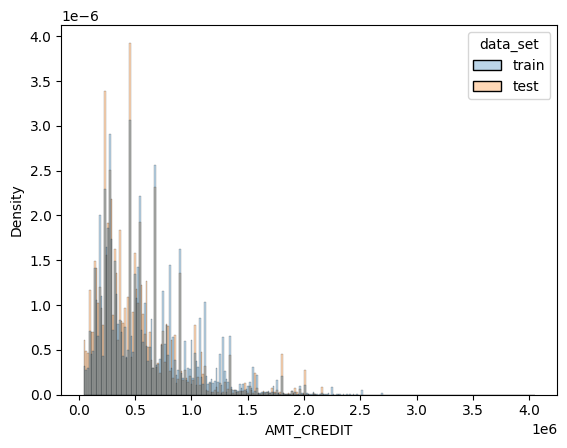

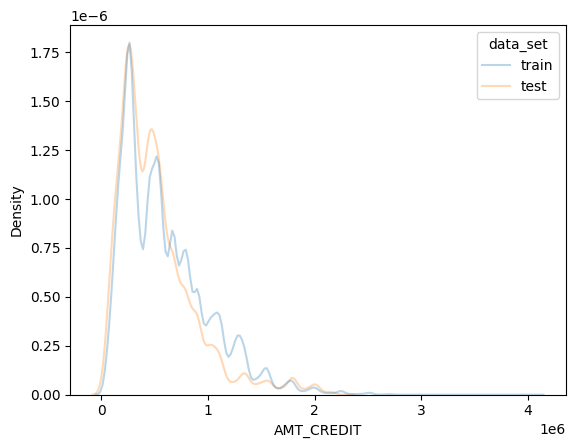

In [216]:
## 以AMT_CREDIT为例
sns.histplot(data = show, 
             x = 'AMT_CREDIT', 
             stat = 'density', 
             hue = 'data_set', 
             common_norm = False, 
             alpha = 0.3)
plt.show()

sns.kdeplot(data = show, 
            x = 'AMT_CREDIT', 
            hue = 'data_set', 
            common_norm = False, 
            alpha = 0.3)
plt.show()

### 柱状图-类别特征分布  
seaborn.histplot  
seaborn.countplot  

<Axes: xlabel='Density', ylabel='OCCUPATION_TYPE'>

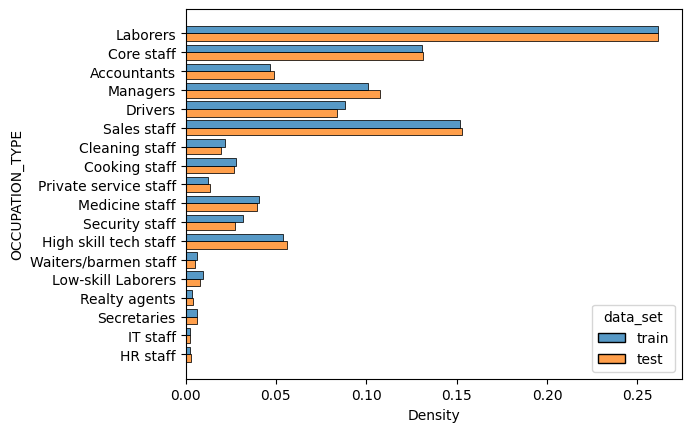

In [217]:
## 以OCCUPATION_TYPE为例
sns.histplot(data = show, 
             y = 'OCCUPATION_TYPE', 
             stat = 'density', 
             hue = 'data_set', 
             common_norm = False, 
             multiple = 'dodge', 
             shrink = 0.8)

<Axes: xlabel='Missing_train', ylabel='Row'>

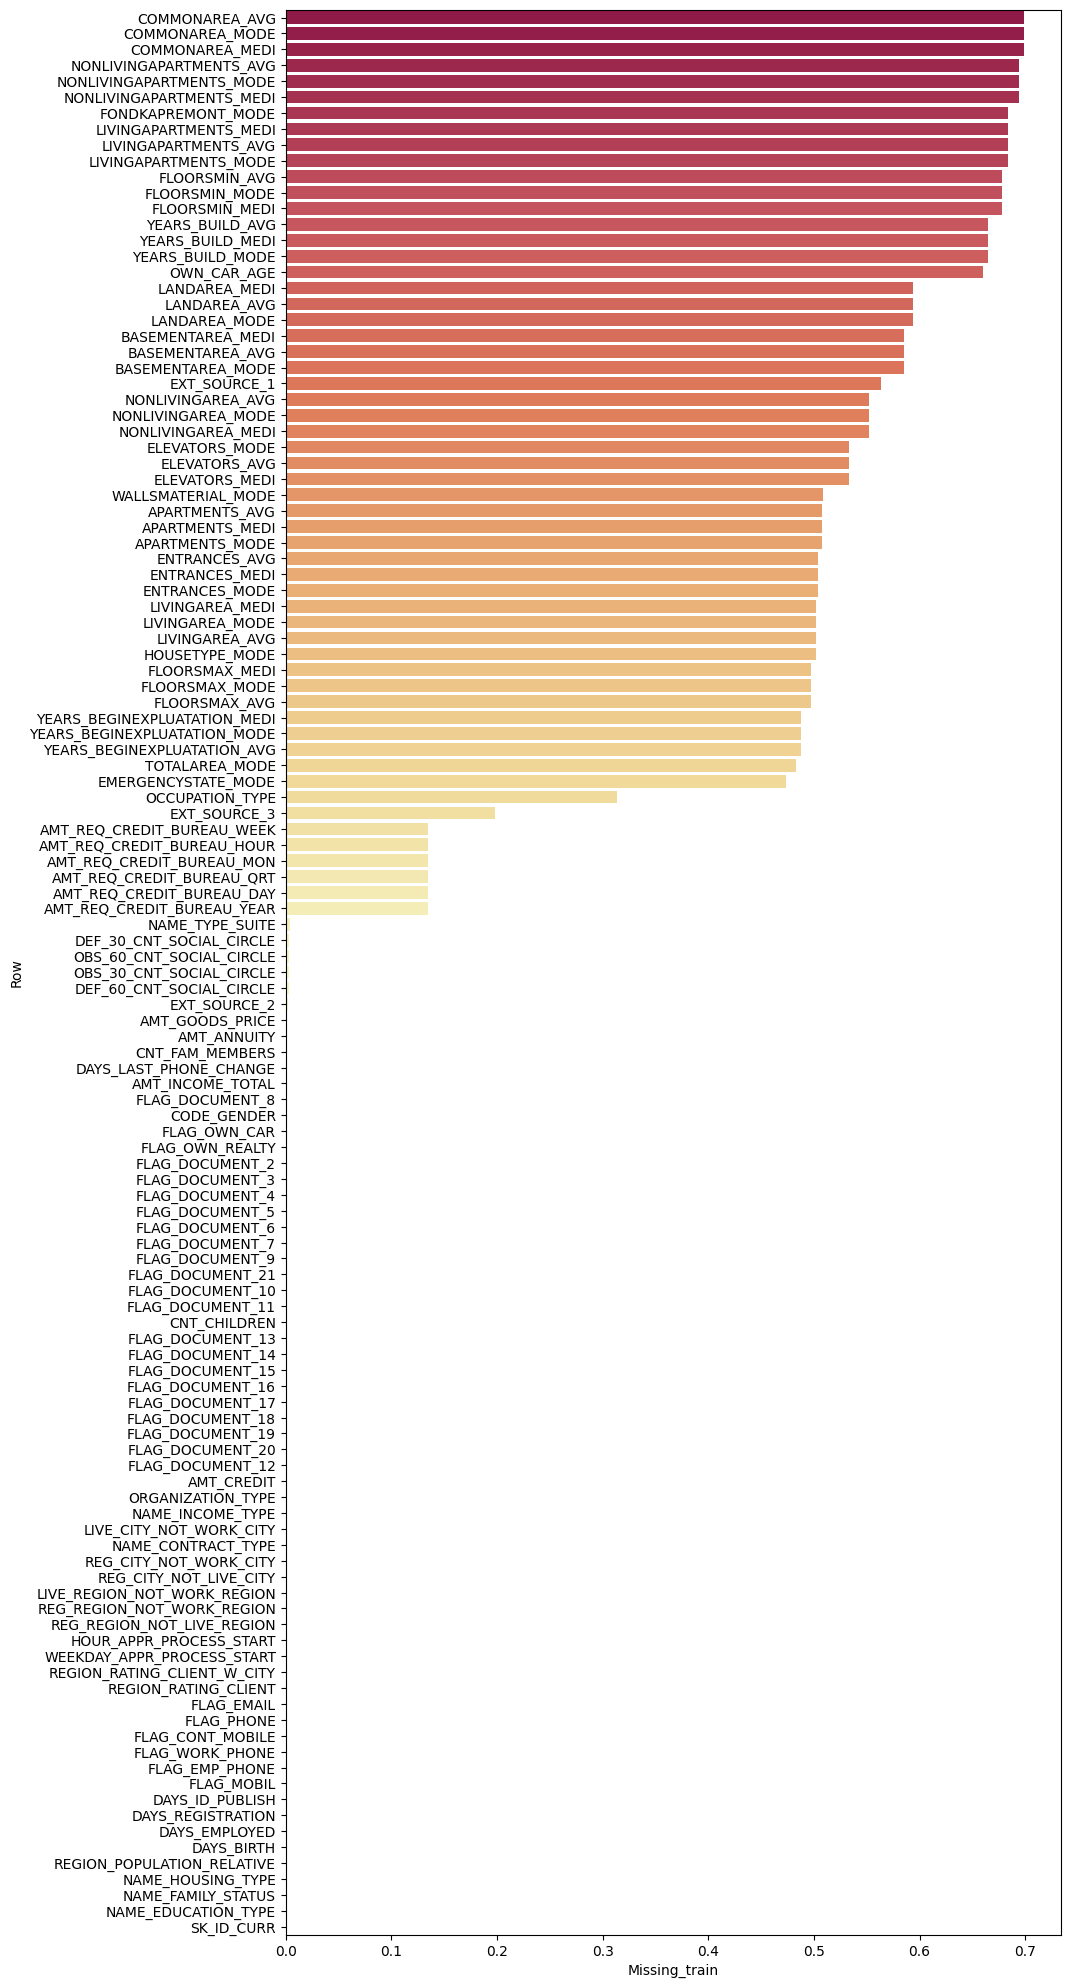

In [218]:
## 缺失值分布
fig = plt.figure(figsize = (10, 25))
sns.barplot(data = feature_des.sort_values(by = 'Missing_train', ascending = False), 
            x = 'Missing_train', 
            y = 'Row', 
            palette = 'Spectral')

### 箱线图-数据分散程度，异常值
seaborn.boxplot

<Axes: xlabel='OCCUPATION_TYPE', ylabel='AMT_CREDIT'>

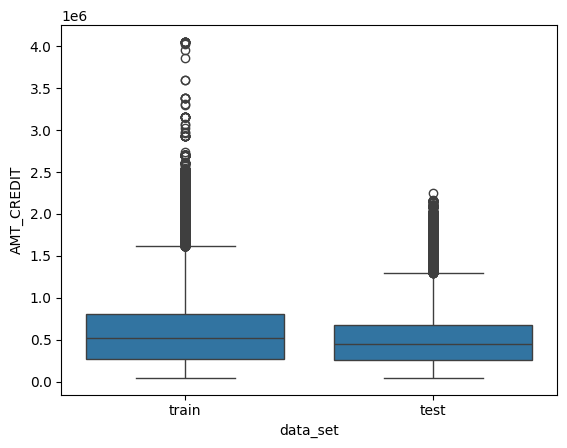

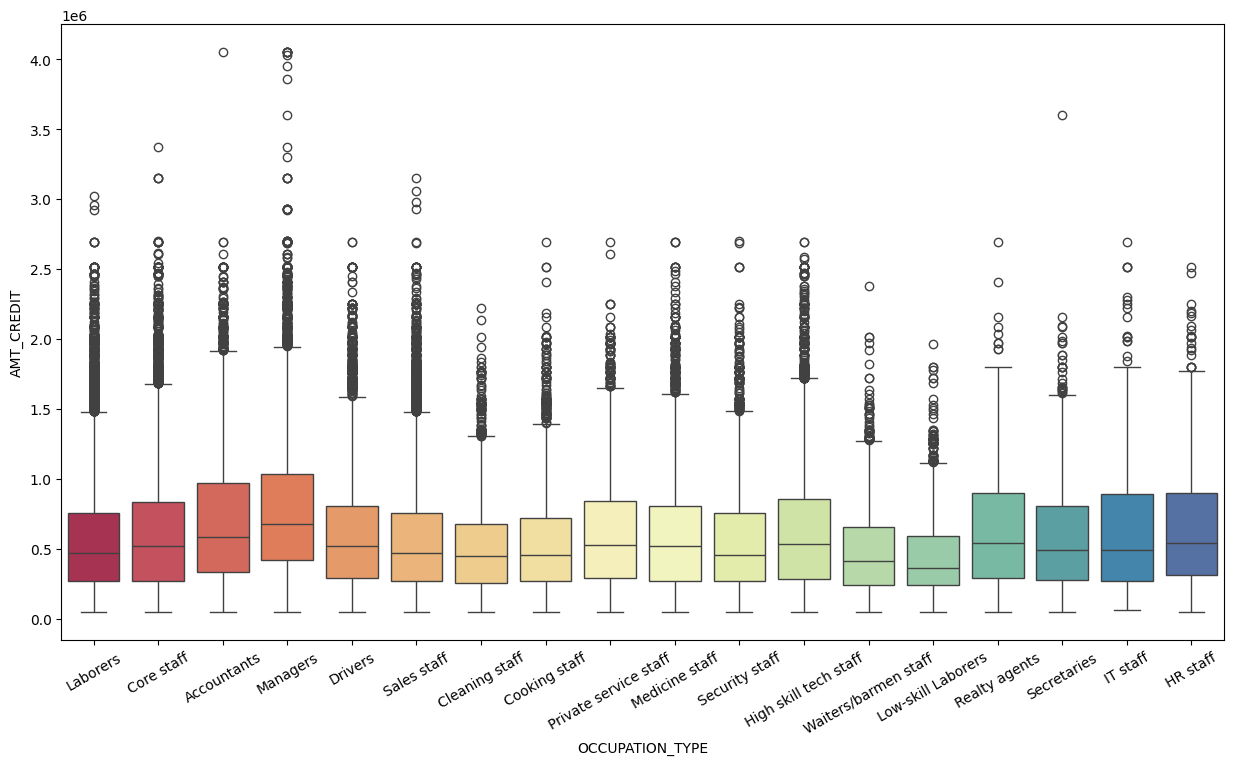

In [232]:
## 以AMT_CREDIT为例
sns.boxplot(data = show, 
            x = 'data_set',  
            y = 'AMT_CREDIT')

## 更常见的用法
fig = plt.figure(figsize = (15, 8))
plt.xticks(rotation = 30)
sns.boxplot(data = show, 
            x = 'OCCUPATION_TYPE', 
            y = 'AMT_CREDIT', 
            palette = 'Spectral')

### 热力图-特征相关性，不常用  
sns.heatmap

<Axes: >

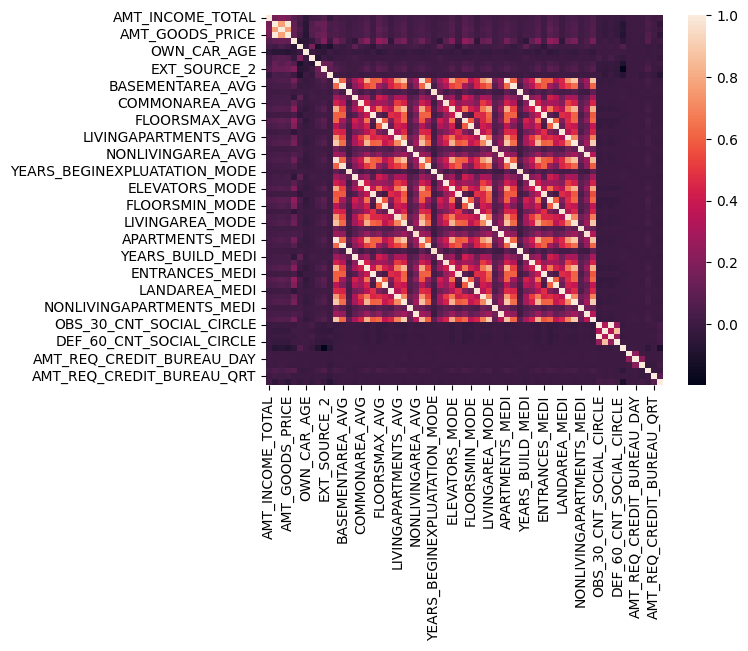

In [ ]:
sns.heatmap(app_train[nfeatures].corr())

### 子图-汇总所有特征
plt.subplot  

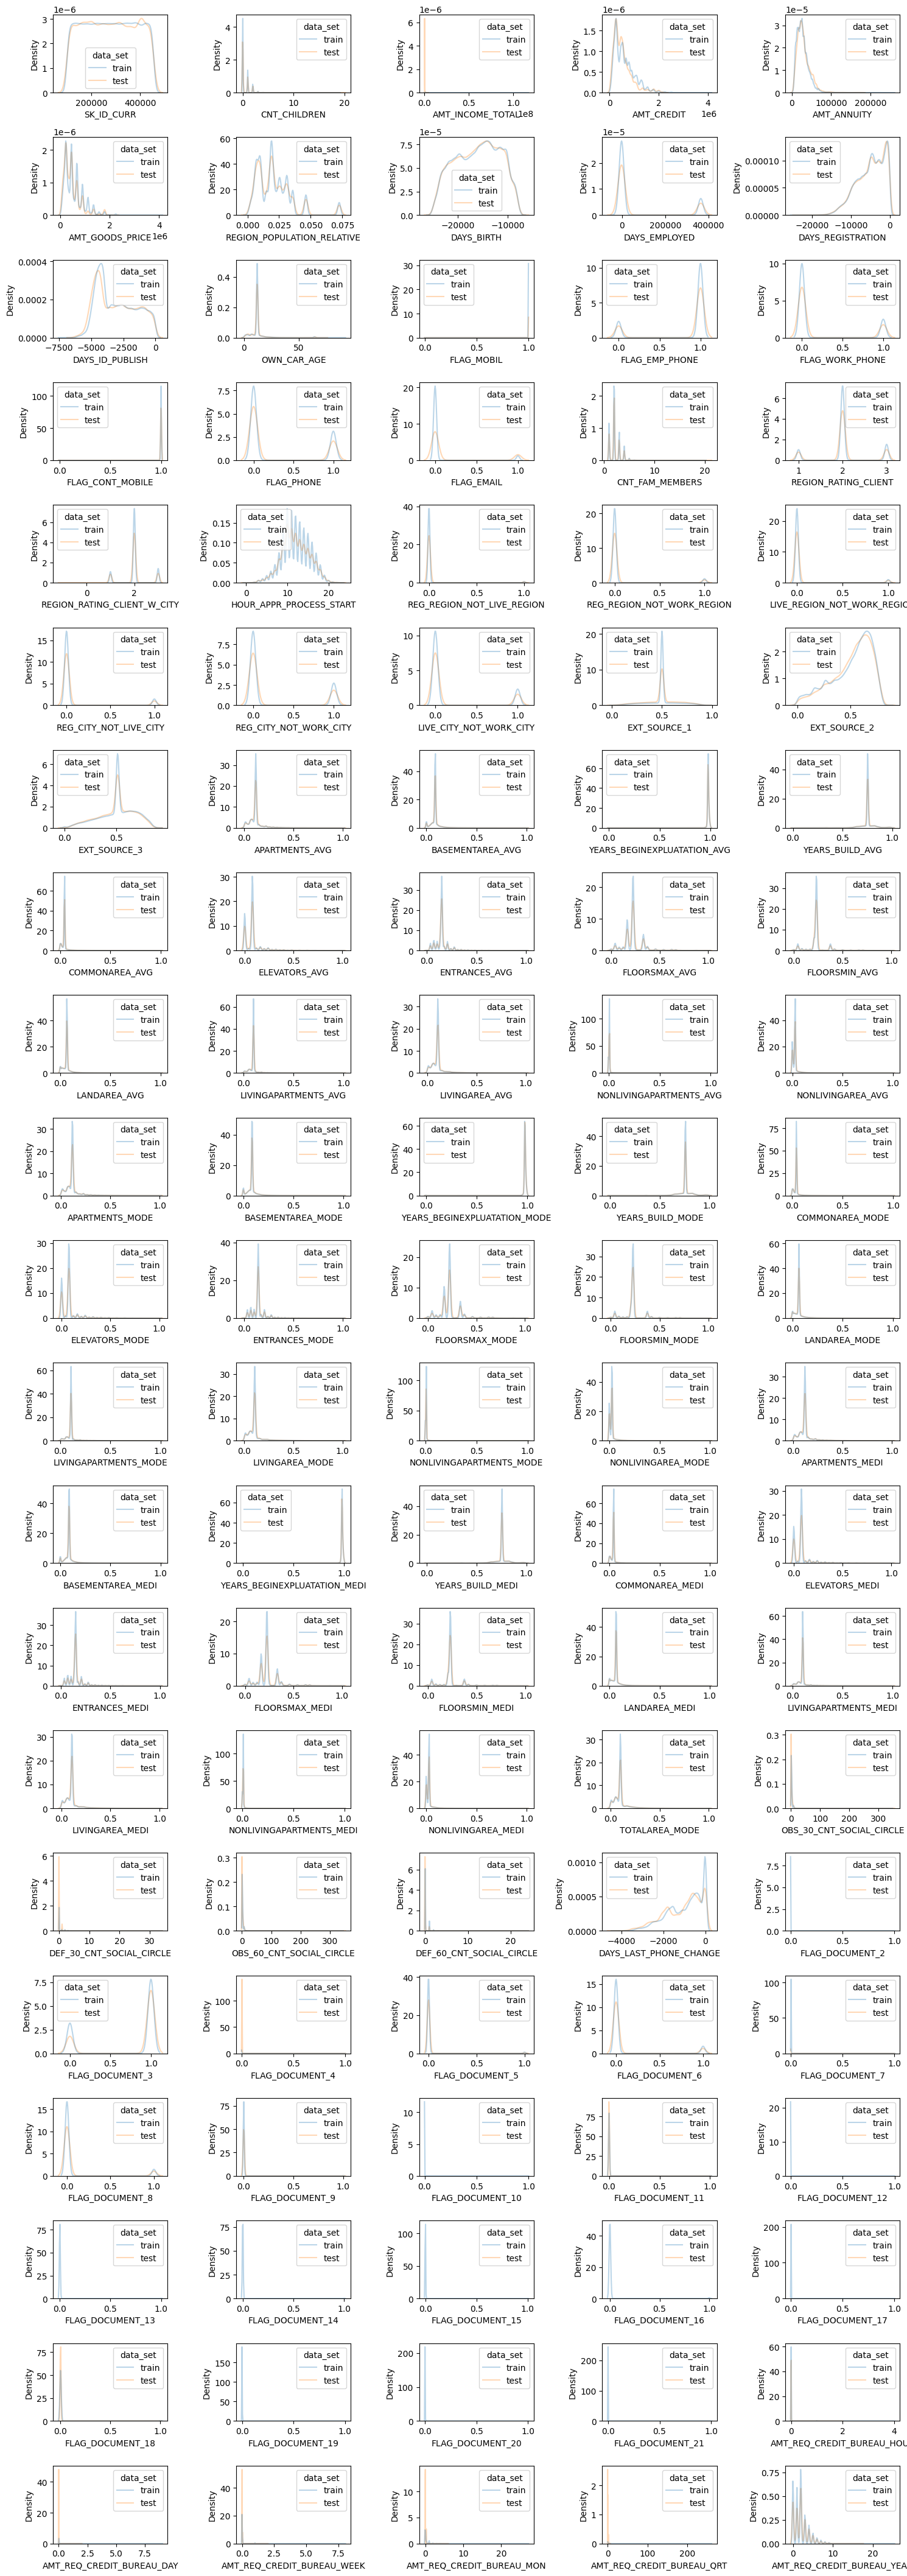

In [233]:
## 以数值特征直方图为例

col = 5
row = int(len(nfeatures) / col + 1)
width = 3
height = 2

fig = plt.figure(figsize = (width*col, height*row))

for i, feature in enumerate(nfeatures): 
    plt.subplot(row, col, i+1)
    sns.kdeplot(data = show, 
                x = feature, 
                hue = 'data_set', 
                common_norm = False, 
                alpha = 0.3)
plt.tight_layout()

fig.savefig('../img/numeric_feature_distribution.jpg', dpi = 100)
plt.show()